In [170]:
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
from scipy import stats
from sklearn.decomposition import PCA
from pca import pca
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor
import  matplotlib.pyplot as plt
import pickle

In [130]:
def backcalc_and_update_mwt(df, w, m, t):
    df[w].fillna(df[t] - df[m], inplace = True)
    df[m].fillna(df[t] - df[w], inplace = True)
    df[t].fillna(df[m] + df[w], inplace = True)

def update_sat_act(df, sat, act):
    df[sat].fillna(pd.Series(np.int32(1200/36 * df[act] + 400)), inplace = True)
    df[act].fillna(pd.Series(np.int32(36.0/1600.0 * df[sat])), inplace = True)

In [131]:
admit_data = pd.read_csv("datasets/Admission and Test Scores/ADM_2015-2021_data.csv")
numerical_data = admit_data.drop(['admcon1', 'admcon2', 'admcon3', 'admcon4', 'admcon5', 'admcon6', 'admcon7', 'admcon8', 'admcon9'], axis = 1, inplace = False)
numerical_data_unique = numerical_data.groupby(['unitid']).mean()
numerical_data_unique.dropna(subset=['admssn'])
numerical_data_unique_clean = numerical_data_unique.copy()

In [132]:
backcalc_and_update_mwt(numerical_data_unique_clean, 'admssnw', 'admssnm', 'admssn')
backcalc_and_update_mwt(numerical_data_unique_clean, 'enrlw', 'enrlm', 'enrlt')
backcalc_and_update_mwt(numerical_data_unique_clean, 'enrlftw', 'enrlftm', 'enrlft')
backcalc_and_update_mwt(numerical_data_unique_clean, 'enrlptw', 'enrlptm', 'enrlpt')

numerical_data_unique_clean['enrlptw'].fillna(0, inplace=True)
numerical_data_unique_clean['enrlpt'].fillna(0, inplace=True)
numerical_data_unique_clean['enrlptm'].fillna(0, inplace=True)

numerical_data_unique_clean['enrlftw'].fillna(0, inplace=True)
numerical_data_unique_clean['enrlft'].fillna(0, inplace=True)
numerical_data_unique_clean['enrlftm'].fillna(0, inplace=True)

numerical_data_unique_clean['enrlt'].fillna(0, inplace=True)
numerical_data_unique_clean['enrlm'].fillna(0, inplace=True)
numerical_data_unique_clean['enrlw'].fillna(0, inplace=True)

numerical_data_unique_clean['admssn'].fillna(0, inplace=True)
numerical_data_unique_clean['admssnm'].fillna(0, inplace=True)
numerical_data_unique_clean['admssnw'].fillna(0, inplace=True)

numerical_data_unique_clean.drop('satnum', axis = 1, inplace = True)
numerical_data_unique_clean.drop('actnum', axis = 1, inplace = True)
numerical_data_unique_clean.drop('actwr25', axis = 1, inplace = True)
numerical_data_unique_clean.drop('satwr75', axis = 1, inplace = True)
numerical_data_unique_clean.drop('satwr25', axis = 1, inplace = True)
numerical_data_unique_clean.drop('actmt75', axis = 1, inplace = True)

update_sat_act(numerical_data_unique_clean, 'satvr25', 'actcm25')
update_sat_act(numerical_data_unique_clean, 'satvr75', 'actcm75')

In [133]:
imp = IterativeImputer(missing_values=np.nan, estimator = RandomForestRegressor(n_estimators=4,
        max_depth=10,
        bootstrap=True,
        max_samples=0.5,
        n_jobs=2,
        random_state=0,), tol = 1e-2, max_iter = 25)

imp.fit(numerical_data_unique_clean)

IterativeImputer(estimator=RandomForestRegressor(max_depth=10, max_samples=0.5,
                                                 n_estimators=4, n_jobs=2,
                                                 random_state=0),
                 max_iter=25, tol=0.01)

In [134]:
numerical_data_unique_clean_imp = pd.DataFrame(imp.transform(numerical_data_unique_clean), columns=numerical_data_unique_clean.columns, index = numerical_data_unique_clean.index)
numerical_data_unique_clean_imp.reset_index(inplace=True)
numerical_data_unique_clean_imp.index.name = 'index'
numerical_data_unique_clean_imp

,unitid,applcn,applcnm,applcnw,admssn,admssnm,admssnw,enrlt,enrlm,enrlw,...,satvr25,satvr75,satmt25,satmt75,actcm25,actcm75,acten25,acten75,actmt25,year
index,,,,,,,,,,,,,,,,,,,,,
0,100654,8455.142857,2970.571429,5483.714286,7153.428571,2449.428571,4703.142857,1537.142857,632.000000,904.857143,...,406.857143,499.285714,391.428571,495.000000,15.571429,19.285714,14.000000,20.000000,15.000000,2018.0
1,100663,9018.000000,3224.142857,5793.857143,7046.428571,2510.428571,4536.000000,2165.000000,799.000000,1366.000000,...,520.428571,649.714286,527.142857,677.285714,21.714286,28.857143,22.142857,31.428571,19.857143,2018.0
2,100706,4817.000000,2572.857143,2244.142857,3791.857143,2137.714286,1654.142857,1297.714286,817.714286,480.000000,...,562.428571,684.285714,551.428571,704.285714,24.571429,30.857143,24.428571,33.000000,23.571429,2018.0
3,100724,7387.000000,2329.571429,4957.714286,5943.285714,1805.571429,4039.285714,1012.285714,369.714286,642.571429,...,412.857143,498.571429,392.571429,493.571429,15.285714,19.571429,13.857143,19.857143,14.714286,2018.0
4,100751,38622.428571,14712.428571,23910.000000,25567.285714,9786.000000,15781.285714,7100.571429,3029.000000,4071.571429,...,525.714286,641.428571,515.714286,650.000000,22.571429,31.142857,22.571429,33.000000,20.857143,2018.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2482,496681,599.000000,29.000000,570.000000,185.000000,7.000000,178.000000,185.000000,7.000000,178.000000,...,496.325407,590.285204,482.893398,583.275964,20.037554,25.241336,19.000340,25.217433,18.294914,2021.0
2483,496973,27.000000,3.000000,24.000000,26.000000,3.000000,23.000000,18.000000,2.000000,16.000000,...,494.476190,579.464966,467.369589,574.330134,20.037554,25.241336,19.303102,25.401508,18.278253,2021.0
2484,497037,41.000000,3.000000,38.000000,41.000000,3.000000,38.000000,32.000000,2.000000,30.000000,...,494.152976,567.612075,477.857143,568.977976,20.164000,25.356812,19.303102,25.401508,18.440992,2021.0


In [179]:
academic_stats = numerical_data_unique_clean_imp.copy()
public_pnp_finances = pd.read_csv("datasets/Institutional Finances/F_F2_1415-1920_data.csv", low_memory=False)
public_pnp_finances = public_pnp_finances.groupby('unitid').mean().reset_index()
enrollment = pd.read_csv("datasets/Fall Enrollment/EFD_2015-2020_data.csv")
enrollment = enrollment.groupby('unitid').mean().reset_index()
caliber = pd.merge(academic_stats, public_pnp_finances, on='unitid', how='inner')
caliber = pd.merge(caliber, enrollment, on='unitid', how='inner')
caliber = caliber.drop(['year_x', 'year_y', 'year'], axis=1)
caliber

,unitid,applcn,applcnm,applcnw,admssn,admssnm,admssnw,enrlt,enrlm,enrlw,...,rrftin,rrftcta,ret_nmf,ret_pcf,rrptct,rrptex,rrptin,rrptcta,ret_nmp,ret_pcp
0,100937,3128.714286,1308.000000,1820.714286,1760.857143,792.714286,967.714286,325.428571,164.142857,161.285714,...,0.0,355.000000,286.166667,80.500000,NaN,NaN,NaN,NaN,NaN,NaN
1,101073,2203.500000,550.000000,1653.500000,835.500000,199.000000,627.000000,212.500000,156.500000,56.000000,...,0.0,129.666667,56.333333,42.666667,6.000000,0.0,0.0,6.000000,1.666667,18.666667
2,101189,1962.285714,836.428571,1125.714286,1139.000000,521.142857,617.857143,287.571429,159.714286,127.857143,...,0.0,296.333333,169.833333,57.333333,17.166667,0.0,0.0,17.166667,7.666667,44.666667
3,101365,114.285714,46.142857,68.142857,103.142857,43.428571,59.714286,69.142857,31.142857,38.000000,...,0.0,1.833333,0.833333,55.000000,0.666667,0.0,0.0,0.666667,0.333333,50.000000
4,101435,2077.428571,1184.714286,892.714286,1228.428571,687.000000,541.428571,257.285714,149.857143,107.428571,...,0.0,259.000000,169.000000,65.333333,0.000000,0.0,0.0,0.000000,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,494463,209.000000,0.000000,209.000000,190.333333,0.000000,190.333333,173.000000,0.000000,173.000000,...,0.0,148.000000,142.500000,96.500000,NaN,NaN,NaN,NaN,NaN,NaN
1334,494685,89.666667,39.333333,50.333333,71.000000,30.333333,40.666667,60.000000,26.666667,33.333333,...,0.0,43.000000,31.500000,71.000000,1.000000,0.0,0.0,1.000000,0.000000,0.000000
1335,495031,16.000000,16.000000,0.000000,9.500000,9.500000,0.000000,6.000000,6.000000,0.000000,...,0.0,7.000000,5.000000,71.000000,NaN,NaN,NaN,NaN,NaN,NaN
1336,495767,96003.500000,44889.000000,51048.000000,81905.500000,38428.500000,43421.000000,15831.500000,8429.000000,7388.500000,...,0.0,15527.000000,13495.000000,87.000000,181.000000,0.0,0.0,181.000000,105.000000,58.000000


In [180]:
caliber['expense_per_student'] = caliber['f2b02']/caliber['enrlt']
caliber['satcm75'] = caliber['satvr75'] + caliber['satmt75']
caliber['log_sat75_per_dollar'] = np.log((caliber['satvr75'] + caliber['satmt75'])/caliber['expense_per_student'])
caliber['log_act75_per_dollar'] = np.log(caliber['actcm75']/caliber['expense_per_student'])
caliber.replace([np.inf, -np.inf], np.nan, inplace=True)
caliber = caliber.fillna(caliber.median())
caliber

,unitid,applcn,applcnm,applcnw,admssn,admssnm,admssnw,enrlt,enrlm,enrlw,...,rrptct,rrptex,rrptin,rrptcta,ret_nmp,ret_pcp,expense_per_student,satcm75,log_sat75_per_dollar,log_act75_per_dollar
0,100937,3128.714286,1308.000000,1820.714286,1760.857143,792.714286,967.714286,325.428571,164.142857,161.285714,...,1.200000,0.0,0.0,1.200000,0.500000,47.333333,142556.725417,1228.571429,-4.753888,-8.515088
1,101073,2203.500000,550.000000,1653.500000,835.500000,199.000000,627.000000,212.500000,156.500000,56.000000,...,6.000000,0.0,0.0,6.000000,1.666667,18.666667,51400.230588,1189.898313,-3.765775,-7.590722
2,101189,1962.285714,836.428571,1125.714286,1139.000000,521.142857,617.857143,287.571429,159.714286,127.857143,...,17.166667,0.0,0.0,17.166667,7.666667,44.666667,152669.237291,1147.142857,-4.890999,-8.800535
3,101365,114.285714,46.142857,68.142857,103.142857,43.428571,59.714286,69.142857,31.142857,38.000000,...,0.666667,0.0,0.0,0.666667,0.333333,50.000000,79104.678719,1150.794356,-4.230320,-8.058628
4,101435,2077.428571,1184.714286,892.714286,1228.428571,687.000000,541.428571,257.285714,149.857143,107.428571,...,0.000000,0.0,0.0,0.000000,0.000000,47.333333,86339.843605,1128.714286,-4.337212,-8.187993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,494463,209.000000,0.000000,209.000000,190.333333,0.000000,190.333333,173.000000,0.000000,173.000000,...,1.200000,0.0,0.0,1.200000,0.500000,47.333333,153746.929652,1177.460151,-4.859320,-8.697257
1334,494685,89.666667,39.333333,50.333333,71.000000,30.333333,40.666667,60.000000,26.666667,33.333333,...,1.000000,0.0,0.0,1.000000,0.000000,0.000000,41345.650000,1153.991815,-3.578740,-7.395549
1335,495031,16.000000,16.000000,0.000000,9.500000,9.500000,0.000000,6.000000,6.000000,0.000000,...,1.200000,0.0,0.0,1.200000,0.500000,47.333333,278046.666667,1145.762957,-5.491718,-9.307061
1336,495767,96003.500000,44889.000000,51048.000000,81905.500000,38428.500000,43421.000000,15831.500000,8429.000000,7388.500000,...,181.000000,0.0,0.0,181.000000,105.000000,58.000000,483463.158892,1330.000000,-5.895796,-9.687533


In [182]:
aca_df = caliber[['unitid', 'log_sat75_per_dollar', 'log_act75_per_dollar', 'satcm75', 'actcm75', 'expense_per_student', 'f2b02', 'f2c05', 'f2c06', 'f2d11', 'f2d12', 'f2e011', 'f2e021', 'f2e031', 'f2e041', 'f2e051', 'f2e061', 'f2e071', 'f2e081']]
aca_df = aca_df.rename(columns=
                       {
                        'f2b02':'Total expenses',
                        'f2c05':'Institutional grants (funded)',
                        'f2c06':'Institutional grants (unfunded)',
                        'f2d11':'Sales and services of educational activities - Total',
                        'f2d12':'Sales and services of auxiliary enterprises - Total',
                        'f2e011':'Instruction-Total amount',
                        'f2e021':'Research-Total amount',
                        'f2e031':'Public service-Total amount',
                        'f2e041':'Academic support-Total amount',
                        'f2e051':'Student service-Total amount',
                        'f2e061':'Institutional support-Total amount',
                        'f2e071':'Auxiliary enterprises-Total amount',
                        'f2e081':'Net grant aid to students-Total amount'
                        })
m_negs = []
for i in aca_df:
    if i not in {'unitid', 'log_sat75_per_dollar', 'log_act75_per_dollar', 'expense_per_student', 'Total expenses', 'actcm75', 'satcm75'}:
        if aca_df[i].min() < 0:
            print(i)
            m_negs.append(i)
        else:
            aca_df[i + "_per_dollar"] = aca_df[i]/aca_df['Total expenses']
            m_negs.append(i)
aca_df = aca_df.drop(m_negs, axis=1)
aca_df


,unitid,log_sat75_per_dollar,log_act75_per_dollar,satcm75,actcm75,expense_per_student,Total expenses,Institutional grants (funded)_per_dollar,Institutional grants (unfunded)_per_dollar,Sales and services of educational activities - Total_per_dollar,Sales and services of auxiliary enterprises - Total_per_dollar,Instruction-Total amount_per_dollar,Research-Total amount_per_dollar,Public service-Total amount_per_dollar,Academic support-Total amount_per_dollar,Student service-Total amount_per_dollar,Institutional support-Total amount_per_dollar,Auxiliary enterprises-Total amount_per_dollar,Net grant aid to students-Total amount_per_dollar
0,100937,-4.753888,-8.515088,1228.571429,28.571429,142556.725417,4.639203e+07,0.120239,0.349113,0.000000,0.327833,0.308731,0.000000,0.000000,0.070772,0.204256,0.197669,0.211686,0.006885
1,101073,-3.765775,-7.590722,1189.898313,25.963095,51400.230588,1.092255e+07,0.000000,0.066926,0.000000,0.178585,0.309677,0.000000,0.000000,0.043623,0.084801,0.300184,0.261713,0.000000
2,101189,-4.890999,-8.800535,1147.142857,23.000000,152669.237291,4.390331e+07,0.012133,0.271563,0.000000,0.073259,0.397523,0.000000,0.000000,0.070137,0.209641,0.197334,0.101123,0.000000
3,101365,-4.230320,-8.058628,1150.794356,25.025595,79104.678719,5.469524e+06,0.000000,0.186007,0.000000,0.000000,0.403997,0.000000,0.000000,0.056023,0.298759,0.169485,0.000000,0.000000
4,101435,-4.337212,-8.187993,1128.714286,24.000000,86339.843605,2.221401e+07,0.179659,0.291876,0.000000,0.207451,0.300758,0.000000,0.000000,0.073726,0.297051,0.174625,0.153840,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,494463,-4.859320,-8.697257,1177.460151,25.212765,153746.929652,3.784147e+07,0.000000,0.015050,0.000000,0.143982,0.017276,0.000000,0.000000,0.006505,0.004565,0.007449,0.121990,0.000000
1334,494685,-3.578740,-7.395549,1153.991815,25.385384,41345.650000,2.480739e+06,0.010033,0.065556,0.000000,0.000000,0.286861,0.000000,0.000000,0.117500,0.295833,0.262713,0.000000,0.000000
1335,495031,-5.491718,-9.307061,1145.762957,25.241336,278046.666667,1.668280e+06,0.000000,0.636105,0.000000,0.000000,0.313956,0.000000,0.025573,0.000000,0.087929,0.094743,0.000000,0.477798
1336,495767,-5.895796,-9.687533,1330.000000,30.000000,483463.158892,7.653947e+09,0.011316,0.018258,0.014545,0.051884,0.179063,0.123366,0.014536,0.050001,0.026074,0.051233,0.054352,0.000000


In [183]:
scaler = StandardScaler()
scores_scaled = scaler.fit_transform(aca_df.iloc[:, 1:5])
scores_scaled = pd.DataFrame(scores_scaled, columns=aca_df.iloc[:, 1:5].columns)
for col in scores_scaled:
    aca_df.insert(1, col + "_scaled", scores_scaled[col])
aca_df

,unitid,actcm75_scaled,satcm75_scaled,log_act75_per_dollar_scaled,log_sat75_per_dollar_scaled,log_sat75_per_dollar,log_act75_per_dollar,satcm75,actcm75,expense_per_student,...,Sales and services of educational activities - Total_per_dollar,Sales and services of auxiliary enterprises - Total_per_dollar,Instruction-Total amount_per_dollar,Research-Total amount_per_dollar,Public service-Total amount_per_dollar,Academic support-Total amount_per_dollar,Student service-Total amount_per_dollar,Institutional support-Total amount_per_dollar,Auxiliary enterprises-Total amount_per_dollar,Net grant aid to students-Total amount_per_dollar
0,100937,0.832873,0.283750,0.379414,0.283457,-4.753888,-8.515088,1228.571429,28.571429,142556.725417,...,0.000000,0.327833,0.308731,0.000000,0.000000,0.070772,0.204256,0.197669,0.211686,0.006885
1,101073,0.021763,-0.044301,1.551688,1.528214,-3.765775,-7.590722,1189.898313,25.963095,51400.230588,...,0.000000,0.178585,0.309677,0.000000,0.000000,0.043623,0.084801,0.300184,0.261713,0.000000
2,101189,-0.899667,-0.406981,0.017413,0.110733,-4.890999,-8.800535,1147.142857,23.000000,152669.237291,...,0.000000,0.073259,0.397523,0.000000,0.000000,0.070137,0.209641,0.197334,0.101123,0.000000
3,101365,-0.269770,-0.376006,0.958293,0.943013,-4.230320,-8.058628,1150.794356,25.025595,79104.678719,...,0.000000,0.000000,0.403997,0.000000,0.000000,0.056023,0.298759,0.169485,0.000000,0.000000
4,101435,-0.588698,-0.563304,0.794234,0.808357,-4.337212,-8.187993,1128.714286,24.000000,86339.843605,...,0.000000,0.207451,0.300758,0.000000,0.000000,0.073726,0.297051,0.174625,0.153840,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,494463,-0.211566,-0.149809,0.148389,0.150640,-4.859320,-8.697257,1177.460151,25.212765,153746.929652,...,0.000000,0.143982,0.017276,0.000000,0.000000,0.006505,0.004565,0.007449,0.121990,0.000000
1334,494685,-0.157887,-0.348883,1.799204,1.763828,-3.578740,-7.395549,1153.991815,25.385384,41345.650000,...,0.000000,0.000000,0.286861,0.000000,0.000000,0.117500,0.295833,0.262713,0.000000,0.000000
1335,495031,-0.202682,-0.418686,-0.624960,-0.646011,-5.491718,-9.307061,1145.762957,25.241336,278046.666667,...,0.000000,0.000000,0.313956,0.000000,0.025573,0.000000,0.087929,0.094743,0.000000,0.477798
1336,495767,1.277115,1.144134,-1.107471,-1.155041,-5.895796,-9.687533,1330.000000,30.000000,483463.158892,...,0.014545,0.051884,0.179063,0.123366,0.014536,0.050001,0.026074,0.051233,0.054352,0.000000


In [184]:
x = aca_df.iloc[:, 9:]
y = aca_df['log_sat75_per_dollar']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=17)
grid = {
    'n_estimators': [5, 10, 13, 15],
    'max_depth' : [5, 7, 10, 12, 15],
    'eta' : [0.1, 0.17, 0.2, 0.22],
    'grow_policy' : ['depthwise', 'lossguide']
}

model_s = XGBRegressor()
xgbr_cv_s = RandomizedSearchCV(estimator=model_s, param_distributions=grid, cv=10, n_jobs=-1)
xgbr_cv_s.fit(x_train, y_train)
res_s = xgbr_cv_s.best_params_
print(res_s)
xgbr_s = XGBRegressor(n_estimators=res_s["n_estimators"], max_depth=res_s["max_depth"], eta=res_s["eta"], grow_policy=res_s["grow_policy"], eval_metric='rmse').fit(x_train, y_train)
score = xgbr_s.score(x_test, y_test)
preds = xgbr_s.predict(x_test)
mse = mean_squared_error(y_test, preds)
print("Test set R^2 Score: ", score)
print("MSE: ", mse)
print("RMSE: ", mse**(0.5))

/Users/michael/opt/anaconda3/envs/stonks/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/michael/opt/anaconda3/envs/stonks/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/michael/opt/anaconda3/envs/stonks/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/michael/opt/anaconda3/envs/stonks/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecate

{'n_estimators': 15, 'max_depth': 7, 'grow_policy': 'depthwise', 'eta': 0.2}
Test set R^2 Score:  0.8979428358511224
MSE:  0.07328724567122996
RMSE:  0.27071617179479684


In [185]:
x = aca_df.iloc[:, 9:]
y = aca_df['log_act75_per_dollar']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=9)
grid = {
    'n_estimators': [5, 7, 10, 12, 15],
    'max_depth' : [5, 7, 10, 12, 15],
    'eta' : [0.1, 0.15, 0.17, 0.2, 0.22, 0.25],
    'grow_policy' : ['depthwise', 'lossguide']
}

model_a = XGBRegressor()
xgbr_cv_a = RandomizedSearchCV(estimator=model_a, param_distributions=grid, cv=10, n_jobs=-1)
xgbr_cv_a.fit(x_train, y_train)
res_a = xgbr_cv_a.best_params_
print(res_a)
xgbr_a = XGBRegressor(n_estimators=res_a["n_estimators"], max_depth=res_a["max_depth"], eta=res_a["eta"], grow_policy=res_a["grow_policy"], eval_metric='rmse').fit(x_train, y_train)
score = xgbr_a.score(x_test, y_test)
preds = xgbr_a.predict(x_test)
mse = mean_squared_error(y_test, preds)
print("Test set R^2 Score: ", score)
print("MSE: ", mse)
print("RMSE: ", mse**(0.5))

/Users/michael/opt/anaconda3/envs/stonks/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/michael/opt/anaconda3/envs/stonks/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/michael/opt/anaconda3/envs/stonks/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/michael/opt/anaconda3/envs/stonks/lib/python3.9/site-packages/xgboost

{'n_estimators': 15, 'max_depth': 15, 'grow_policy': 'lossguide', 'eta': 0.2}
Test set R^2 Score:  0.8064685522183593
MSE:  0.1323521454035561
RMSE:  0.36380234386759536


In [153]:
x = aca_df.iloc[:, 9:]
y = aca_df['satcm75']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=9)
grid = {
    'n_estimators': [5, 7, 10, 12, 15],
    'max_depth' : [5, 7, 10, 12, 15],
    'eta' : [0.1, 0.15, 0.17, 0.2, 0.25],
    'grow_policy' : ['depthwise', 'lossguide']
}

model_s2 = XGBRegressor()
xgbr_cv_s2 = RandomizedSearchCV(estimator=model_s2, param_distributions=grid, cv=10, n_jobs=-1)
xgbr_cv_s2.fit(x_train, y_train)
res_s2 = xgbr_cv_s2.best_params_
print(res_s2)
xgbr_s2 = XGBRegressor(n_estimators=res_s2["n_estimators"], max_depth=res_s2["max_depth"], eta=res_s2["eta"], grow_policy=res_s2["grow_policy"], eval_metric='rmse').fit(x_train, y_train)
score = xgbr_s2.score(x_test, y_test)
preds = xgbr_s2.predict(x_test)
mse = mean_squared_error(y_test, preds)
print("Test set R^2 Score: ", score)
print("MSE: ", mse)
print("RMSE: ", mse**(0.5))

/Users/michael/opt/anaconda3/envs/stonks/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/michael/opt/anaconda3/envs/stonks/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/michael/opt/anaconda3/envs/stonks/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/michael/opt/anaconda3/envs/stonks/lib/python3.9/site-packages/xgboost

{'n_estimators': 15, 'max_depth': 5, 'grow_policy': 'lossguide', 'eta': 0.25}
Test set R^2 Score:  0.49716758226511004
MSE:  6788.636907270779
RMSE:  82.39318483509895


In [152]:
x = aca_df.iloc[:, 9:]
y = aca_df['actcm75']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=9)
grid = {
    'n_estimators': [5, 7, 10, 12, 15],
    'max_depth' : [5, 7, 10, 12, 15],
    'eta' : [0.05, 0.1, 0.12, 0.15, 0.17, 0.2],
    'grow_policy' : ['depthwise', 'lossguide']
}

model_a2 = XGBRegressor()
xgbr_cv_a2 = RandomizedSearchCV(estimator=model_a2, param_distributions=grid, cv=10, n_jobs=-1)
xgbr_cv_a2.fit(x_train, y_train)
res_a2 = xgbr_cv_a2.best_params_
print(res_a2)
xgbr_a2 = XGBRegressor(n_estimators=res_a2["n_estimators"], max_depth=res_a2["max_depth"], eta=res_a2["eta"], grow_policy=res_a2["grow_policy"], eval_metric='rmse').fit(x_train, y_train)
score = xgbr_a2.score(x_test, y_test)
preds = xgbr_a2.predict(x_test)
mse = mean_squared_error(y_test, preds)
print("Test set R^2 Score: ", score)
print("MSE: ", mse)
print("RMSE: ", mse**(0.5))

/Users/michael/opt/anaconda3/envs/stonks/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/michael/opt/anaconda3/envs/stonks/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/michael/opt/anaconda3/envs/stonks/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/michael/opt/anaconda3/envs/stonks/lib/python3.9/site-packages/xgboost

{'n_estimators': 10, 'max_depth': 7, 'grow_policy': 'lossguide', 'eta': 0.15}
Test set R^2 Score:  -2.1235922565690077
MSE:  32.11522792674471
RMSE:  5.667029903463075


In [191]:
x = aca_df.iloc[:, 9:]
y = aca_df['log_sat75_per_dollar_scaled']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=17)
grid = {
    'n_estimators': [5, 7, 10, 12, 15],
    'max_depth' : [5, 7, 10, 12, 15],
    'eta' : [0.05, 0.1, 0.12, 0.15, 0.17, 0.2],
    'grow_policy' : ['depthwise', 'lossguide']
}

model_s_s = XGBRegressor()
xgbr_cv_s_s = RandomizedSearchCV(estimator=model_s_s, param_distributions=grid, cv=10, n_jobs=-1)
xgbr_cv_s_s.fit(x_train, y_train)
res_s_s = xgbr_cv_s_s.best_params_
print(res_s_s)
xgbr_s_s = XGBRegressor(n_estimators=res_s_s["n_estimators"], max_depth=res_s_s["max_depth"], eta=res_s_s["eta"], grow_policy=res_s_s["grow_policy"], eval_metric='rmse').fit(x_train, y_train)
score = xgbr_s_s.score(x_test, y_test)
preds = xgbr_s_s.predict(x_test)
mse = mean_squared_error(y_test, preds)
print("Test set R^2 Score: ", score)
print("MSE: ", mse)
print("RMSE: ", mse**(0.5))

/Users/michael/opt/anaconda3/envs/stonks/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/michael/opt/anaconda3/envs/stonks/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/michael/opt/anaconda3/envs/stonks/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/michael/opt/anaconda3/envs/stonks/lib/python3.9/site-packages/xgboost

{'n_estimators': 15, 'max_depth': 5, 'grow_policy': 'lossguide', 'eta': 0.17}
Test set R^2 Score:  0.9582615491943598
MSE:  0.04756386544504272
RMSE:  0.21809141534008789


In [203]:
score = xgbr_s_s.score(x_test, y_test)
preds = xgbr_s_s.predict(x_test)
mse = mean_squared_error(y_test, preds)
print("Test Set r^2 Score: ", score)
print("MSE: ", mse)
print("RMSE: ", mse**(0.5))
xgbr_s_s

Test Set r^2 Score:  0.9837109856998818
MSE:  0.017916129812345142
RMSE:  0.1338511479679765


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eta=0.17, eval_metric='rmse', gamma=0, gpu_id=-1,
             grow_policy='lossguide', importance_type=None,
             interaction_constraints='', learning_rate=0.170000002,
             max_delta_step=0, max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=15, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, ...)

In [192]:
x = aca_df.iloc[:, 9:]
y = aca_df['log_act75_per_dollar_scaled']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=9)
grid = {
    'n_estimators': [5, 7, 10, 11, 12],
    'max_depth' : [5, 8, 10, 11, 12],
    'eta' : [0.1, 0.15, 0.17, 0.2, 0.22, 0.25],
    'grow_policy' : ['depthwise', 'lossguide']
}

model_a_s = XGBRegressor()
xgbr_cv_a_s = RandomizedSearchCV(estimator=model_a_s, param_distributions=grid, cv=10, n_jobs=-1)
xgbr_cv_a_s.fit(x_train, y_train)
res_a_s = xgbr_cv_a_s.best_params_
print(res_a_s)
xgbr_a_s = XGBRegressor(n_estimators=res_a_s["n_estimators"], max_depth=res_a_s["max_depth"], eta=res_a_s["eta"], grow_policy=res_a_s["grow_policy"], eval_metric='rmse').fit(x_train, y_train)
score = xgbr_a_s.score(x_test, y_test)
preds = xgbr_a_s.predict(x_test)
mse = mean_squared_error(y_test, preds)
print("Test set R^2 Score: ", score)
print("MSE: ", mse)
print("RMSE: ", mse**(0.5))

/Users/michael/opt/anaconda3/envs/stonks/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/michael/opt/anaconda3/envs/stonks/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/michael/opt/anaconda3/envs/stonks/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/michael/opt/anaconda3/envs/stonks/lib/python3.9/site-packages/xgboost

{'n_estimators': 12, 'max_depth': 12, 'grow_policy': 'depthwise', 'eta': 0.25}
Test set R^2 Score:  0.9821214917247658
MSE:  0.019664398913804105
RMSE:  0.1402298075082616


In [204]:
score = xgbr_a_s.score(x_test, y_test)
preds = xgbr_a_s.predict(x_test)
mse = mean_squared_error(y_test, preds)
print("Test Set r^2 Score: ", score)
print("MSE: ", mse)
print("RMSE: ", mse**(0.5))
xgbr_a_s

Test Set r^2 Score:  0.9821214917247658
MSE:  0.019664398913804105
RMSE:  0.1402298075082616


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eta=0.25, eval_metric='rmse', gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.25, max_delta_step=0,
             max_depth=12, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=12, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, ...)

In [190]:
x = aca_df.iloc[:, 9:]
y = aca_df['satcm75_scaled']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=9)
grid = {
    'n_estimators': [5, 7, 10, 12, 15],
    'max_depth' : [5, 7, 10, 12, 15],
    'eta' : [0.1, 0.15, 0.17, 0.2, 0.25],
    'grow_policy' : ['depthwise', 'lossguide']
}

model_s2_s = XGBRegressor()
xgbr_cv_s2_s = RandomizedSearchCV(estimator=model_s2_s, param_distributions=grid, cv=10, n_jobs=-1)
xgbr_cv_s2_s.fit(x_train, y_train)
res_s2_s = xgbr_cv_s2_s.best_params_
print(res_s2_s)
xgbr_s2_s = XGBRegressor(n_estimators=res_s2_s["n_estimators"], max_depth=res_s2_s["max_depth"], eta=res_s2_s["eta"], grow_policy=res_s2_s["grow_policy"], eval_metric='rmse').fit(x_train, y_train)
score = xgbr_s2_s.score(x_test, y_test)
preds = xgbr_s2_s.predict(x_test)
mse = mean_squared_error(y_test, preds)
print("Test set R^2 Score: ", score)
print("MSE: ", mse)
print("RMSE: ", mse**(0.5))

/Users/michael/opt/anaconda3/envs/stonks/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/michael/opt/anaconda3/envs/stonks/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/michael/opt/anaconda3/envs/stonks/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/michael/opt/anaconda3/envs/stonks/lib/python3.9/site-packages/xgboost

{'n_estimators': 7, 'max_depth': 5, 'grow_policy': 'depthwise', 'eta': 0.2}
Test set R^2 Score:  0.5336371384185556
MSE:  0.4530509882305073
RMSE:  0.6730906240845339


In [156]:
x = aca_df.iloc[:, 9:]
y = aca_df['actcm75_scaled']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=9)
grid = {
    'n_estimators': [5, 7, 10, 12, 15],
    'max_depth' : [5, 7, 10, 12, 15],
    'eta' : [0.05, 0.1, 0.12, 0.15, 0.17, 0.2],
    'grow_policy' : ['depthwise', 'lossguide']
}

model_a2_s = XGBRegressor()
xgbr_cv_a2_s = RandomizedSearchCV(estimator=model_a2_s, param_distributions=grid, cv=10, n_jobs=-1)
xgbr_cv_a2_s.fit(x_train, y_train)
res_a2_s = xgbr_cv_a2_s.best_params_
print(res_a2_s)
xgbr_a2_s = XGBRegressor(n_estimators=res_a2_s["n_estimators"], max_depth=res_a2_s["max_depth"], eta=res_a2_s["eta"], grow_policy=res_a2_s["grow_policy"], eval_metric='rmse').fit(x_train, y_train)
score = xgbr_a2_s.score(x_test, y_test)
preds = xgbr_a2_s.predict(x_test)
mse = mean_squared_error(y_test, preds)
print("Test set R^2 Score: ", score)
print("MSE: ", mse)
print("RMSE: ", mse**(0.5))

/Users/michael/opt/anaconda3/envs/stonks/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/michael/opt/anaconda3/envs/stonks/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/michael/opt/anaconda3/envs/stonks/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/michael/opt/anaconda3/envs/stonks/lib/python3.9/site-packages/xgboost

{'n_estimators': 10, 'max_depth': 5, 'grow_policy': 'depthwise', 'eta': 0.17}
Test set R^2 Score:  0.5117750838237296
MSE:  0.48541183445563496
RMSE:  0.6967150310246184


In [158]:
aca_df

,unitid,actcm75_scaled,satcm75_scaled,log_act75_per_dollar_scaled,log_sat75_per_dollar_scaled,log_sat75_per_dollar,log_act75_per_dollar,satcm75,actcm75,Total expenses,...,Sales and services of educational activities - Total_per_dollar,Sales and services of auxiliary enterprises - Total_per_dollar,Instruction-Total amount_per_dollar,Research-Total amount_per_dollar,Public service-Total amount_per_dollar,Academic support-Total amount_per_dollar,Student service-Total amount_per_dollar,Institutional support-Total amount_per_dollar,Auxiliary enterprises-Total amount_per_dollar,Net grant aid to students-Total amount_per_dollar
0,100937,0.832873,0.283750,0.379414,0.283457,-4.753888,-8.515088,1228.571429,28.571429,4.639203e+07,...,0.000000,0.327833,0.308731,0.000000,0.000000,0.070772,0.204256,0.197669,0.211686,0.006885
1,101073,0.021763,-0.044301,1.551688,1.528214,-3.765775,-7.590722,1189.898313,25.963095,1.092255e+07,...,0.000000,0.178585,0.309677,0.000000,0.000000,0.043623,0.084801,0.300184,0.261713,0.000000
2,101189,-0.899667,-0.406981,0.017413,0.110733,-4.890999,-8.800535,1147.142857,23.000000,4.390331e+07,...,0.000000,0.073259,0.397523,0.000000,0.000000,0.070137,0.209641,0.197334,0.101123,0.000000
3,101365,-0.269770,-0.376006,0.958293,0.943013,-4.230320,-8.058628,1150.794356,25.025595,5.469524e+06,...,0.000000,0.000000,0.403997,0.000000,0.000000,0.056023,0.298759,0.169485,0.000000,0.000000
4,101435,-0.588698,-0.563304,0.794234,0.808357,-4.337212,-8.187993,1128.714286,24.000000,2.221401e+07,...,0.000000,0.207451,0.300758,0.000000,0.000000,0.073726,0.297051,0.174625,0.153840,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,494463,-0.211566,-0.149809,0.148389,0.150640,-4.859320,-8.697257,1177.460151,25.212765,3.784147e+07,...,0.000000,0.143982,0.017276,0.000000,0.000000,0.006505,0.004565,0.007449,0.121990,0.000000
1334,494685,-0.157887,-0.348883,1.799204,1.763828,-3.578740,-7.395549,1153.991815,25.385384,2.480739e+06,...,0.000000,0.000000,0.286861,0.000000,0.000000,0.117500,0.295833,0.262713,0.000000,0.000000
1335,495031,-0.202682,-0.418686,-0.624960,-0.646011,-5.491718,-9.307061,1145.762957,25.241336,1.668280e+06,...,0.000000,0.000000,0.313956,0.000000,0.025573,0.000000,0.087929,0.094743,0.000000,0.477798
1336,495767,1.277115,1.144134,-1.107471,-1.155041,-5.895796,-9.687533,1330.000000,30.000000,7.653947e+09,...,0.014545,0.051884,0.179063,0.123366,0.014536,0.050001,0.026074,0.051233,0.054352,0.000000


In [188]:
aca_df.to_csv('score_prediction.csv')

In [193]:
xgbr_s_s.save_model('log_sat75_per_dollar_scaled_model.json')
xgbr_a_s.save_model('log_act75_per_dollar_scaled_model.json')

In [172]:
list(aca_df.iloc[:, 9:])

['Total expenses',
 'expense_per_student_per_dollar',
 'Institutional grants (funded)_per_dollar',
 'Institutional grants (unfunded)_per_dollar',
 'Sales and services of educational activities - Total_per_dollar',
 'Sales and services of auxiliary enterprises - Total_per_dollar',
 'Instruction-Total amount_per_dollar',
 'Research-Total amount_per_dollar',
 'Public service-Total amount_per_dollar',
 'Academic support-Total amount_per_dollar',
 'Student service-Total amount_per_dollar',
 'Institutional support-Total amount_per_dollar',
 'Auxiliary enterprises-Total amount_per_dollar',
 'Net grant aid to students-Total amount_per_dollar']

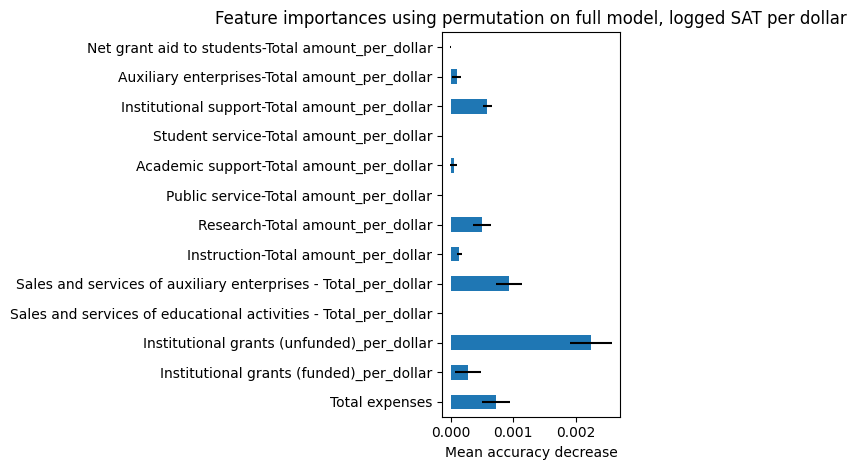

In [210]:
result = permutation_importance(
    xgbr_s_s, x_test, y_test, n_repeats=10, random_state=19, n_jobs=-1
)
forest_importances = pd.Series(result.importances_mean[1:], index=list(aca_df.iloc[:, 10:]))

fig, ax = plt.subplots()
forest_importances.plot.barh(xerr=result.importances_std[1:], ax=ax)
ax.set_title("Feature importances using permutation on full model, logged SAT per dollar")
ax.set_xlabel("Mean accuracy decrease")
fig.tight_layout()
plt.savefig('sat_feature_importances.png')
plt.show()

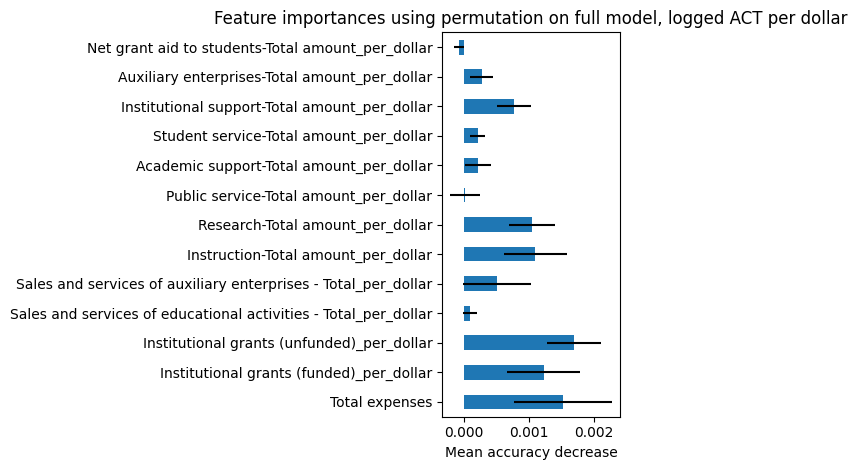

In [211]:
result = permutation_importance(
    xgbr_a_s, x_test, y_test, n_repeats=10, random_state=19, n_jobs=-1
)
forest_importances = pd.Series(result.importances_mean[1:], index=list(aca_df.iloc[:, 10:]))

fig, ax = plt.subplots()
forest_importances.plot.barh(xerr=result.importances_std[1:], ax=ax)
ax.set_title("Feature importances using permutation on full model, logged ACT per dollar")
ax.set_xlabel("Mean accuracy decrease")
fig.tight_layout()
plt.savefig('act_feature_importances.png')
plt.show()

In [206]:
aca_df['log_sat75_per_dollar_scaled'].std()

1.000373901676929